In [1]:
import sys, os
import numpy as np
import pylab as pl
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import matplotlib
import sklearn as sk
import sklearn.discriminant_analysis as da
import sklearn.neighbors as knn
from datetime import  datetime, timedelta
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk import pos_tag
from datetime import datetime

/Users/dmalav/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
gdp_data = pd.read_csv('../data/gdp.csv', sep = '\t')
gdp_data.head()

,quarter,gdp_current,gdp_chained
0,1947q1,243.1,1934.5
1,1947q2,246.3,1932.3
2,1947q3,250.1,1930.3
3,1947q4,260.3,1960.7
4,1948q1,266.2,1989.5


In [3]:
def quarter_to_date(quarter):
    year = quarter[:-2]
    q = quarter[-2:]
    if q == 'q1':
        return (datetime(year=int(year), month=1, day=1).date(), 
                datetime(year=int(year), month=3, day=31).date())
    elif q == 'q2':
        return (datetime(year=int(year), month=4, day=1).date(),
                datetime(year=int(year), month=6, day=30).date())
    elif q == 'q3':
        return (datetime(year=int(year), month=7, day=1).date(), 
                datetime(year=int(year), month=9, day=30).date())
    elif q == 'q4':
        return (datetime(year=int(year), month=10, day=1).date(), 
                datetime(year=int(year), month=12, day=31).date())



print quarter_to_date('1947q1')
print quarter_to_date('1947q2')
print quarter_to_date('1947q3')
print quarter_to_date('1947q4')

(datetime.date(1947, 1, 1), datetime.date(1947, 3, 31))
(datetime.date(1947, 4, 1), datetime.date(1947, 6, 30))
(datetime.date(1947, 7, 1), datetime.date(1947, 9, 30))
(datetime.date(1947, 10, 1), datetime.date(1947, 12, 31))


In [4]:
gdp_data['start_date'] = gdp_data['quarter'].apply(lambda x: quarter_to_date(x)[0])
gdp_data['end_date'] = gdp_data['quarter'].apply(lambda x: quarter_to_date(x)[0])
gdp_data.head()

,quarter,gdp_current,gdp_chained,start_date,end_date
0,1947q1,243.1,1934.5,1947-01-01,1947-01-01
1,1947q2,246.3,1932.3,1947-04-01,1947-04-01
2,1947q3,250.1,1930.3,1947-07-01,1947-07-01
3,1947q4,260.3,1960.7,1947-10-01,1947-10-01
4,1948q1,266.2,1989.5,1948-01-01,1948-01-01


In [ ]:
plt.figure(figsize=(10,5))
plt.title('US GDP')
plt.plot(gdp_data['end_date'], gdp_data['gdp_current'], label='Current $')
plt.plot(gdp_data['end_date'], gdp_data['gdp_chained'], label='Chained (2009) $')
plt.xlabel('Year')
plt.ylabel('GDP ($M)')
plt.legend()
plt.show()

In [ ]:
gdp_data['rate'] = gdp_data['gdp_chained'].pct_change(1)
gdp_data.head()

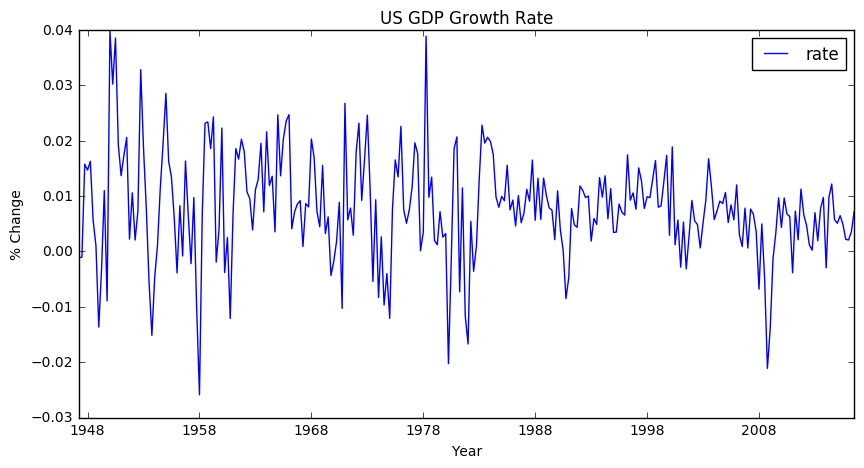

In [62]:
plt.figure(figsize=(10,5))
plt.title('US GDP Growth Rate')
plt.plot(gdp_data['end_date'], gdp_data['rate'])
plt.xlabel('Year')
plt.ylabel('% Change')
plt.legend()
plt.show()

<h1>Data Collection</h1>
<p>
The New York Times (NYT) provides an Article Search API to fetch data related to news articles. This API does not return full text of articles, but it will return a number of helpful metadata such as subject terms, abstract, lead paragraph, and date, as well as URLs, which one could conceivably use to scrape the full text of articles. For this project we will be collecting lead paragraph for business articles for specified time period.
</p>
<p>In order to request data from NYT an API key must be requested from http://developer.nytimes.com/. The article search API is limited to 1K calls per day, and 5 calls per second. These limits impose challenge for collecting as much data as possible for a day and time period. Based on the limited time for the project, the data collection was limited to two API calls or 20 article per day. This allowed to request 500 days worth of data per day.</p>

<p>A python wrapper was developed around NYT Article Search API to get articles for a given start and end date. The reqested lead paragraph data are then store in a file with file name reflecting the day in the format YYYYMMDD.txt<p>


In [13]:
# Data collection using NYTimes API
class NYTArticlesApi(object):
    def __init__(self, api_key):
        self.api_key = api_key
        self.url = 'https://api.nytimes.com/svc/search/v2/articlesearch.json'

    def request_articles(self, start_date, end_date, page):
        start_date_str = start_date.strftime('%Y%m%d')
        end_date_str = end_date.strftime('%Y%m%d')

        params = {
            'api-key': self.api_key,
            'fq': "section_name:Business",
            'begin_date': start_date_str,
            'end_date': end_date_str,
            'fl': "lead_paragraph",
            'sort': "newest",
            'page': page
        }
        r = requests.get(self.url, params=params)

        if r.status_code == 200:
            response = json.loads(r.text)
            docs = response['response']['docs']
            return [item['lead_paragraph'] for item in docs]

        print "Error: api response: ", r.status_code, "Message :", r.text
        return None

    def fetch_articles(self, start_date, end_date, data_dir):
        cur_date = start_date
        while cur_date >= end_date:
            print 'Processing ', cur_date, '...'
            articles = []
            # get 2 pages for each day, i.e. 20 articles
            for page in range(2):
                articles_page = self.request_articles(cur_date, cur_date, page)
                if articles_page:
                    articles += articles_page
                else:
                    print "No data for page {0}.".format(page)
                    time.sleep(1)
                    break
                time.sleep(1)

            if len(articles) > 0:
                file_name = data_dir + cur_date.strftime('%Y%m%d') + '.txt'
                with open(file_name, 'wb',) as f:
                    for text in articles:
                        if text:
                            f.write(text.encode('utf-8').strip() + '\n')

            else:
                print "Error fetching articles for {0}.".format(cur_date)
                file_name = data_dir + "last_date.txt"
                with open(file_name, 'wb',) as f:
                    f.write(cur_date.strftime('%Y%m%d'))
                return

            cur_date -= timedelta(days=1)

In [5]:
def load_data(data_dir, start_date, end_date):
    data = {}
    cur_date = start_date
    while cur_date >= end_date:
        file_name = data_dir + cur_date.strftime('%Y%m%d') + '.txt'
        if os.path.exists(file_name):
            with open(file_name, 'rb',) as f:
                articles = f.readlines()
            data[cur_date] = " ".join(articles)

        cur_date -= timedelta(days=1)

    return data

In [9]:
print "Running sentiment analysis..."
start_date = datetime(year=2016, month=10, day=31).date()
end_date = datetime(year=2016, month=10, day=31).date()
data_dir = '../data/articles/'


data = load_data(data_dir, start_date, end_date)

stop_words = set(stopwords.words('english'))
ps = PorterStemmer()

Running sentiment analysis...


In [11]:
print data
for date, text in data.iteritems():
    word_tokens = word_tokenize(text)
#     filtered_tokens = [w for w in word_tokens if not w in stop_words]
    stemmed_tokens = [w.lower() for w in word_tokens if not w in stop_words]
    print pos_tag(stemmed_tokens)

{datetime.date(2016, 10, 31): "The AT&T-Time Warner merger raises concerns about the combination of a huge wireless company with a major movie studio and popular cable channels.\n Japan's industrial output stalled in September in a worrying sign that the economy, already struggling to mount a sure-footed recovery, may be losing some momentum due to weak consumer spending and exports.\n Asian stocks got off to a shaky start on Monday as investors were rattled by news that the FBI is planning to review more emails related to Democratic presidential candidate Hillary Clinton's private server, just a week before the election.\n China's insurance regulator recently visited foreign life insurance firms and intermediaries in Beijing as part of investigations into the illegal sale of insurance products in Hong Kong to mainland Chinese, the Shanghai Securities news reported on Monday without disclosing its sources.\n General Electric Co is nearing an about $30 billion deal to merge its oil and 